# Search the articles

This notebook will search the articles for the project exploiting the [Media Cloud](https://mediacloud.org/) database.
One have to set the customizable parameters:

1. `PATH_TO_DATA` is the Path object for saving the constructed DataFrames;
2. `MY_KEY` parameter is the user key every Media Cloud user has been provided once signed up, for more info go [here](https://github.com/mediacloud/backend/blob/master/doc/api_2_0_spec/api_2_0_spec.md#authentication);
3. `MIN_LEGTH` parameter is the minimiun length that a word must have to be considered for the word vector;
4. `MIN_FREQUENCY` parameter is the minimum frequency a word must appear in at least one article to be considered for the word vector;
5. `MAX_ARTICLES` parameter set the maximum number of articles to search;
6. `N_THREADS` parameter set the number of threads for parallelizing some of the procedures.

In [1]:
import json
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
import mediacloud.api
from IPython.display import JSON
import datetime
import matplotlib.pyplot as plt
from collections import Counter
from functools import partial

## These following have to be customized
PATH_TO_DATA = Path('../data')
# Media Cloud account keys
LOLLO_KEY_1 = 'fa108cf51bdb186f9f037bc196d0183b18b24caac3158416a858b5a9b58dc143'
LOLLO_KEY_2 = '66aa9cf8dbd642b0e47f6811764cbe451a84d9429b8d2b3647c97c0af8fd40f5'
DANI_KEY = '00692be452b478dc158269f890533127ceb444b9f0cc05411ad154f67d55fec1'
# for joblib multithreading
N_THREADS = -1

Mediatags for restricting queries

In [2]:
ITALY_M_TAG = 'tags_id_media:38380117'
US_M_TAG = 'tags_id_media:38379429'
UK_M_TAG = 'tags_id_media:38381111'
FRANCE_M_TAG = 'tags_id_media:38379799'
GERMANY_M_TAG = 'tags_id_media:38379816'
SPAIN_M_TAG = 'tags_id_media:38002034'

Function for getting info about articles.

In [3]:
# TODO: limit max number of stories
# TODO: check for repeated stories
def all_matching_stories(mc_client, q, fq):
    """
    Return all the stories matching a query within Media Cloud. Page through the results automatically.
    :param mc_client: a `mediacloud.api.MediaCloud` object instantiated with your API key already
    :param q: your boolean query
    :param fq: your date range query
    :return: a list of media cloud story items
    """
    last_id = 0
    more_stories = True
    stories = []
    while more_stories:
        page = mc_client.storyList(q, fq, last_processed_stories_id=last_id, rows=500, sort='processed_stories_id')
        print("  got one page with {} stories".format(len(page)))
        if len(page) == 0:
            more_stories = False
        else:
            stories += page[:-1]
            last_id = page[-1]['processed_stories_id']
    return stories

Function for processing info from stories.

In [4]:
def process_info(story):
    return pd.DataFrame(
            [{
                'article_id': story['stories_id'],
                'timestamp': str(story['publish_date']),
                'source': story['media_id'],
            }]
        )

Function for processing word matrix.

In [5]:
def process_word_matrix(key):
    word_vector_dict = stories_words['word_matrix'][key]
    word_vector = np.zeros(n_words)
    for kkey in word_vector_dict.keys():
        word_vector[eval(kkey)] = word_vector_dict[kkey]
    word_vector = list([key])+list(word_vector)
    return pd.DataFrame([word_vector], columns=columns)

Functions for filtering the word matrix dataframe.

In [6]:
special_characters = ".\!@#$%^&*()+?_=,<>/"

def has_numbers(inputString):
    return any(char.isdigit() for char in inputString)

def has_special_chars(inputString):
    return any(c in special_characters for c in inputString)

def process_drop_columns(col):
    # tmp = pd.to_numeric(words_df[col])
    # if len(col) < MIN_LENGTH or len(tmp[tmp>0]) == 0 or has_numbers(col) or has_special_chars(col):
    if has_numbers(col) or has_special_chars(col):
        return col

Function for processing ids.

In [7]:
def process_ids(id, articles_ids):
    if id in articles_ids:
        return None
    else:
        return id

Instantiate the Media Cloud client, and getting some info about the status of the account.

In [4]:
mc = mediacloud.api.MediaCloud(LOLLO_KEY_2)
print('Media cloud version '+str(mediacloud.__version__))
# make sure your connection and API key work by asking for the high-level system statistics
# and print it out as a nice json tree - we'll use this later (only works in Jupyter Lab)
JSON(mc.stats())
# italy collection 38380117

Media cloud version 3.12.5


MCException: ('Error - got a HTTP status code of 403 with the message "Forbidden", body: {"error":"Error(s): Invalid API key. All API keys were reset on May 1, 2020, so make sure you are using a new one.\'\\n"}', 403)

Query definition.
The following cells will run the queries that will get articles info and the word matrix (used in the project).
Some stats will be visualized.
One has to customize the filters for getting what he/she is interested in.
Remind that the epidemic model works fine for events that have a rapid spreading (popular, interesting) and then die, because of that one has to pay attention not only to the argument but also to the time windows.
For more info about constructing the query look [here](https://github.com/mediacloud/backend/blob/master/doc/api_2_0_spec/api_2_0_spec.md#query-parameters-5).

Russia shooting.

Processing 4322 stories


  0%|          | 0/4322 [00:00<?, ?stories/s]

   article_id           timestamp  source
0  1926391701 2021-05-10 00:00:00  278722
4  1926430980 2021-05-10 00:00:00   20270
1  1926386660 2021-05-10 00:01:35    1123
2  1926388426 2021-05-10 00:01:35   63091
3  1926416043 2021-05-10 00:58:55    1123


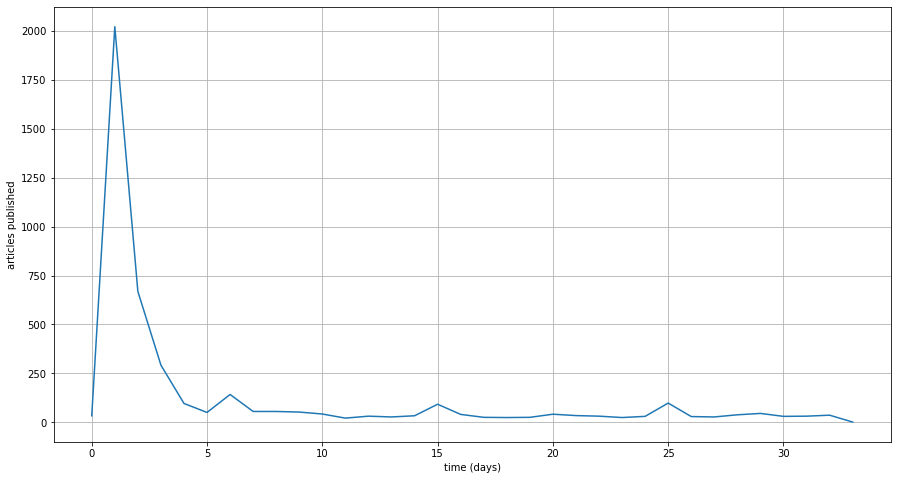

In [74]:
world_russia_query = '(russia AND school AND shooting) OR (russia AND scuola AND sparatoria) OR (russie AND école AND fusillade) OR (rusia AND colegio AND tiroteo) OR  (russland AND schule AND (angriff OR schießen))'
start_date = datetime.date(2021, 5, 10)
end_date = datetime.date(2021, 6, 10)
if not Path(PATH_TO_DATA/'world_russia_all_stories.json').exists():
    date_range = mc.dates_as_query_clause(start_date, end_date)
    story_count = mc.storyCount(world_russia_query, date_range)['count']
    print('Media Cloud found {} stories'.format(story_count)) # 4322
    all_stories = all_matching_stories(
        mc,
        world_russia_query,
        date_range)
    with open(PATH_TO_DATA/'world_russia_all_stories.json', 'x') as json_file:
        json.dump(all_stories, json_file)
else:
    with open(PATH_TO_DATA/'world_russia_all_stories.json', 'r') as json_file:
        all_stories = json.load(json_file)
print('Processing {} stories'.format(len(list(all_stories))))
stories_iterator = tqdm(
    list(all_stories),
    leave=True,
    unit='stories',
)
articles_info = Parallel(n_jobs=N_THREADS)(delayed(process_info)(i) for i in stories_iterator)
info_df = pd.concat(articles_info, axis=0).reset_index().drop('index', 1)
info_df['timestamp'] = pd.to_datetime(info_df.timestamp)
info_df = info_df.sort_values(by='timestamp')
del articles_info
print(info_df.head())
info_df['time_diff'] = info_df['timestamp'].map(lambda x: round((x-info_df['timestamp'][0]).total_seconds()/3600/24))
fig = plt.figure(figsize=(15,8))
plt.plot(list(Counter(info_df['time_diff']).values()))
plt.xlabel('time (days)')
plt.ylabel('articles published')
plt.grid()
plt.show()
if not Path(PATH_TO_DATA/'world_russia_word_matrix.json').exists():
    print('Getting word matrix')
    stories_words = mc.storyWordMatrix(
        world_russia_query,
        date_range,
        rows=len(list(all_stories)))
    with open(PATH_TO_DATA/'world_russia_word_matrix.json', 'w') as json_file:
        json.dump(stories_words, json_file)
else:
    with open(PATH_TO_DATA/'world_russia_word_matrix.json', 'r') as json_file:
        all_stories = json.load(json_file)

Norway terroristic attack.

Media Cloud found 3875 stories
  got one page with 500 stories
  got one page with 500 stories
  got one page with 500 stories
  got one page with 500 stories
  got one page with 500 stories
  got one page with 500 stories
  got one page with 500 stories
  got one page with 384 stories
  got one page with 0 stories
Processing 3884 stories


  0%|          | 0/3884 [00:00<?, ?stories/s]

    article_id           timestamp  source
2   1996327005 2021-07-21 00:00:00  125334
3   1996330114 2021-07-21 00:00:00   69934
58  1996453424 2021-07-21 00:00:00   40268
52  1996434927 2021-07-21 00:00:00  396984
1   1996202810 2021-07-21 00:19:04   84097


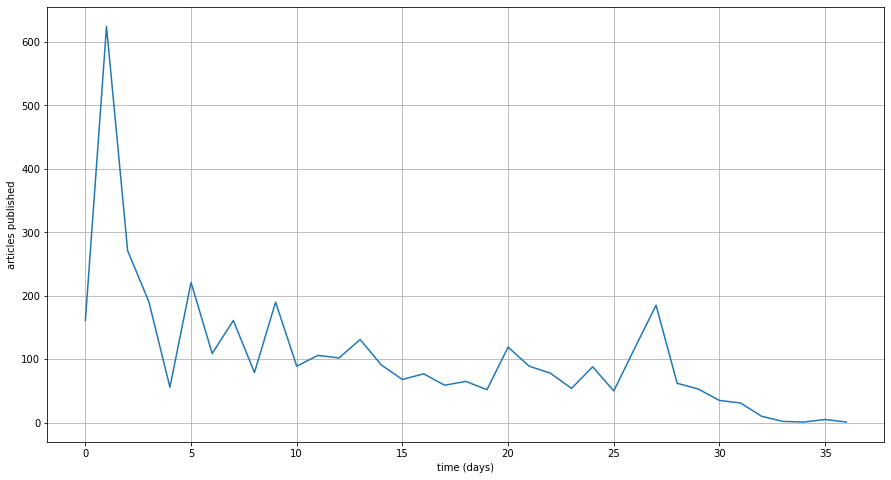

In [77]:
world_norway_query = '(attack AND norway) OR (attacco AND norvegia) OR (ataque AND noruega) OR (attacke AND norwegen) OR (attaque AND norvège)'
start_date = datetime.date(2021, 7, 21)
end_date = datetime.date(2021, 8, 21)
if not Path(PATH_TO_DATA/'world_norway_all_stories.json').exists():
    date_range = mc.dates_as_query_clause(start_date, end_date)
    story_count = mc.storyCount(world_norway_query, date_range)['count']
    print('Media Cloud found {} stories'.format(story_count)) # 3875
    all_stories = all_matching_stories(
        mc,
        world_norway_query,
        date_range)
    with open(PATH_TO_DATA/'world_norway_all_stories.json', 'x') as json_file:
        json.dump(all_stories, json_file)
else:
    with open(PATH_TO_DATA/'world_norway_all_stories.json', 'r') as json_file:
        all_stories = json.load(json_file)
print('Processing {} stories'.format(len(list(all_stories))))
stories_iterator = tqdm(
    list(all_stories),
    leave=True,
    unit='stories',
)
articles_info = Parallel(n_jobs=N_THREADS)(delayed(process_info)(i) for i in stories_iterator)
info_df = pd.concat(articles_info, axis=0).reset_index().drop('index', 1)
info_df['timestamp'] = pd.to_datetime(info_df.timestamp)
info_df = info_df.sort_values(by='timestamp')
del articles_info
print(info_df.head())
info_df['time_diff'] = info_df['timestamp'].map(lambda x: round((x-info_df['timestamp'][0]).total_seconds()/3600/24))
fig = plt.figure(figsize=(15,8))
plt.plot(list(Counter(info_df['time_diff']).values()))
plt.xlabel('time (days)')
plt.ylabel('articles published')
plt.grid()
plt.show()
if not Path(PATH_TO_DATA/'world_norway_word_matrix.json').exists():
    print('Getting word matrix')
    stories_words = mc.storyWordMatrix(
        world_norway_query,
        date_range,
        rows=len(list(all_stories)))
    with open(PATH_TO_DATA/'world_norway_word_matrix.json', 'w') as json_file:
        json.dump(stories_words, json_file)
else:
    with open(PATH_TO_DATA/'world_norway_word_matrix.json', 'r') as json_file:
        all_stories = json.load(json_file)

Capitol hill mob.

In [ ]:
world_capitol_hill_query = 'capitol AND hill AND (assault OR mob OR asalto OR agression OR angriff OR assalto)'
start_date = datetime.date(2021, 1, 5)
end_date = datetime.date(2021, 2, 5)
if not Path(PATH_TO_DATA/'world_capitol_hill_all_stories.json').exists():
    date_range = mc.dates_as_query_clause(start_date, end_date)
    story_count = mc.storyCount(world_capitol_hill_query, date_range)['count']
    print('Media Cloud found {} stories'.format(story_count)) # 45004
    all_stories = all_matching_stories(
        mc,
        world_capitol_hill_query,
        date_range)
    with open(PATH_TO_DATA/'world_capitol_hill_all_stories.json', 'x') as json_file:
        json.dump(all_stories, json_file)
else:
    with open(PATH_TO_DATA/'world_capitol_hill_all_stories.json', 'r') as json_file:
        all_stories = json.load(json_file)
print('Processing {} stories'.format(len(list(all_stories))))
stories_iterator = tqdm(
    list(all_stories),
    leave=True,
    unit='stories',
)
articles_info = Parallel(n_jobs=N_THREADS)(delayed(process_info)(i) for i in stories_iterator)
info_df = pd.concat(articles_info, axis=0).reset_index().drop('index', 1)
info_df['timestamp'] = pd.to_datetime(info_df.timestamp)
info_df = info_df.sort_values(by='timestamp')
del articles_info
print(info_df.head())
info_df['time_diff'] = info_df['timestamp'].map(lambda x: round((x-info_df['timestamp'][0]).total_seconds()/3600/24))
fig = plt.figure(figsize=(15,8))
plt.plot(list(Counter(info_df['time_diff']).values()))
plt.xlabel('time (days)')
plt.ylabel('articles published')
plt.grid()
plt.show()
if not Path(PATH_TO_DATA/'world_capitol_hill_word_matrix.json').exists():
    print('Getting word matrix')
    stories_words = mc.storyWordMatrix(
        world_capitol_hill_query,
        date_range,
        rows=len(list(all_stories)))
    with open(PATH_TO_DATA/'world_capitol_hill_word_matrix.json', 'w') as json_file:
        json.dump(stories_words, json_file)
else:
    with open(PATH_TO_DATA/'world_capitol_hill_word_matrix.json', 'r') as json_file:
        all_stories = json.load(json_file)

Charlie Hebdo terrorist attack.

In [86]:
# TODO: proper filtering to reduce the number of stories
query = 'charlie hebdo AND '+UK_M_TAG
start_date = datetime.date(2015, 1, 7)
end_date = datetime.date(2015, 2, 7)
date_range = mc.dates_as_query_clause(start_date, end_date)
story_count = mc.storyCount(query,
                            date_range)['count']
print('Media Cloud found {} stories'.format(story_count)) # WORLD 141156, ITALY 999, FRANCE 4310, US 3613, UK 69

Media Cloud found 69 stories


In [3]:
stories = {
    'norway_attack': ['world_norway_all_stories.json', 'world_norway_word_matrix.json'],
    'russia_shooting': ['world_russia_all_stories.json', 'world_russia_word_matrix.json'],
    'capitol_hill': ['world_capitol_hill_all_stories.json', 'world_capitol_hill_word_matrix.json'],
}
story_to_elaborate = 'norway_attack' # 'russia_shooting' # 'capitol_hill'
with open(PATH_TO_DATA/stories[story_to_elaborate][0]) as json_file:
    all_stories = json.load(json_file)
# JSON(all_stories)
with open(PATH_TO_DATA/stories[story_to_elaborate][1]) as json_file:
    stories_words = json.load(json_file)
# JSON(stories_words)

<IPython.core.display.JSON object>

The following cell will build the words vector DataFrame using `pandas` library.
The DataFrame will have a column (`id`) with the id of the article, and also one column per word named with that word.

In [35]:
words_df = pd.DataFrame()
n_words = len(stories_words['word_list'])
columns = [stories_words['word_list'][i][0] for i in range(len(stories_words['word_list']))]
columns.insert(0,'article_id')

keys_iterator = tqdm(
    stories_words['word_matrix'].keys(),
    leave=True,
    unit='articles',
)

results = Parallel(n_jobs=N_THREADS)(delayed(process_word_matrix)(i) for i in keys_iterator)
# results

  0%|          | 0/1913 [00:00<?, ?articles/s]

In [39]:
words_df = pd.concat(results, axis=0).reset_index().drop('index', 1)#.drop('level_0', 1)
# del results
words_df.head()

article_id  intanto  tarrio  votat  quando    è  banner  vota  dandolo  \
0  1815167122      0.0     0.0    0.0     0.0  0.0     0.0   0.0      0.0   
1  1815303448      1.0     2.0    1.0     1.0  3.0     1.0   1.0      1.0   
2  1815314004      1.0     2.0    1.0     1.0  3.0     1.0   1.0      1.0   
3  1815387215      0.0     0.0    0.0     0.0  0.0     0.0   0.0      0.0   
4  1815537720      0.0     0.0    0.0     0.0  0.0     0.0   0.0      0.0   

   fiamm  ...  l'oligarchia  dopò  gravano  sovrappongono  ascoltatori  \
0    0.0  ...           0.0   0.0      0.0            0.0          0.0   
1    1.0  ...           0.0   0.0      0.0            0.0          0.0   
2    1.0  ...           0.0   0.0      0.0            0.0          0.0   
3    0.0  ...           0.0   0.0      0.0            0.0          0.0   
4    0.0  ...           0.0   0.0      0.0            0.0          0.0   

   sopravvivrà  paragonando  attaccavano  stento  un'audi  
0          0.0          0.0          0.0     0.0      0.0  
1          0.0          0.0          0.0     0.0      0.0  
2          0.0          0.0          0.0     0.0      0.0  
3          0.0          0.0          0.0     0.0      0.0  
4          0.0          0.0          0.0     0.0      0.0  

[5 rows x 41567 columns]

The following cell will drop out the column corresponding to the word that should not be counted for the words vectors as set by the parameters `MIN_LENGTH` and `MIN_FREQUENCY`.

In [67]:
cols_iterator = tqdm(
    words_df.columns[1:],
    leave=True,
    unit='columns',
)

cols = Parallel(n_jobs=N_THREADS)(delayed(process_drop_columns)(i) for i in cols_iterator)
# cols

  0%|          | 0/41566 [00:00<?, ?columns/s]

Elaborate columns to exclude errors while dropping them.

In [69]:
cols = [x for x in cols if (str(x) != 'nan' and str(x) != 'NaN' and str(x) != '' and str(x) != 'None')]
words_df = words_df.drop(cols, 1)
words_df['article_id'] = pd.to_numeric(words_df.article_id)
# del cols
words_df.head()

article_id  intanto  tarrio  votat  quando    è  banner  vota  dandolo  \
0  1815167122      0.0     0.0    0.0     0.0  0.0     0.0   0.0      0.0   
4  1815537720      0.0     0.0    0.0     0.0  0.0     0.0   0.0      0.0   
1  1815303448      1.0     2.0    1.0     1.0  3.0     1.0   1.0      1.0   
2  1815314004      1.0     2.0    1.0     1.0  3.0     1.0   1.0      1.0   
3  1815387215      0.0     0.0    0.0     0.0  0.0     0.0   0.0      0.0   

   fiamm  ...  l'oligarchia  dopò  gravano  sovrappongono  ascoltatori  \
0    0.0  ...           0.0   0.0      0.0            0.0          0.0   
4    0.0  ...           0.0   0.0      0.0            0.0          0.0   
1    1.0  ...           0.0   0.0      0.0            0.0          0.0   
2    1.0  ...           0.0   0.0      0.0            0.0          0.0   
3    0.0  ...           0.0   0.0      0.0            0.0          0.0   

   sopravvivrà  paragonando  attaccavano  stento  un'audi  
0          0.0          0.0          0.0     0.0      0.0  
4          0.0          0.0          0.0     0.0      0.0  
1          0.0          0.0          0.0     0.0      0.0  
2          0.0          0.0          0.0     0.0      0.0  
3          0.0          0.0          0.0     0.0      0.0  

[5 rows x 40022 columns]

The following cell will build the article info DataFrame using `pandas` library.
Data about articles will be extracted by usign a query to Media Cloud for the single story.
The DataFrame will have a column (`id`) with the id of the article.
Column `timestamp` will carry the data in which the article has been published.
Columns `source` will carry the media id of the media in which the article has been published.
It is necessary to reordering in cronological order the articles.

In [24]:
print("Stories found {}".format(len(all_stories)))

stories_iterator = tqdm(
    list(all_stories),
    leave=True,
    unit='stories',
)

articles_info = Parallel(n_jobs=N_THREADS)(delayed(process_info)(i) for i in stories_iterator)
# articles_info

Stories found 1913


  0%|          | 0/1913 [00:00<?, ?stories/s]

In [25]:
info_df = pd.concat(articles_info, axis=0).reset_index().drop('index', 1)
info_df['timestamp'] = pd.to_datetime(info_df.timestamp)
info_df = info_df.sort_values(by='timestamp')
# del articles_info
info_df.head()

article_id           timestamp  source
0  1815167122 2021-01-05 01:43:17   41552
4  1815537720 2021-01-05 03:49:27   39834
1  1815303448 2021-01-05 04:58:00  300123
2  1815314004 2021-01-05 04:58:00   39740
3  1815387215 2021-01-05 06:56:36  300147

It's then necessary to filter out from word matrix those stories than have not been elaborated.

In [64]:
print("Stories found by querying info {}".format(len(all_stories)))
print("Stories found by word matrix info {}".format(len(list(stories_words['word_matrix'].keys()))))
print("Stories to drop {}".format(len(all_stories)-len(list(stories_words['word_matrix'].keys()))))

ids_iterator = tqdm(
    list(info_df['article_id']),
    leave=True,
    unit='ids',
)
    
ids_to_drop = Parallel(n_jobs=N_THREADS)(delayed(partial(process_ids, articles_ids=list(words_df['article_id'])))(i) for i in ids_iterator)
len(ids_to_drop)

Stories found by querying info 1913
Stories found by word matrix info 1913
Stories to drop 0


  0%|          | 0/1913 [00:00<?, ?ids/s]

1913

In [65]:
info_df.drop((info_df[info_df['article_id'] == ids_to_drop]).index).head()

article_id                  timestamp  source
0     1815167122 2021-01-05 01:43:17.000000   41552
4     1815537720 2021-01-05 03:49:27.000000   39834
1     1815303448 2021-01-05 04:58:00.000000  300123
2     1815314004 2021-01-05 04:58:00.000000   39740
3     1815387215 2021-01-05 06:56:36.000000  300147
...          ...                        ...     ...
1901  1843599484 2021-02-05 09:45:53.000000   40216
1902  1843692039 2021-02-05 10:26:43.000000   40216
1903  1843800908 2021-02-05 13:30:07.636862   38859
1906  1844581078 2021-02-05 21:14:00.000000  334276
1907  1845326478 2021-02-05 22:55:00.000000  334276

[1913 rows x 3 columns]

The same order must be given to the other DataFrame obviously.

In [66]:
info_df = info_df.sort_values(by='timestamp')
words_df = words_df.reindex(info_df.index.tolist())
# words_df

Finally, the DataFrames are save in the data folder, defined by `PATH_TO_DATA`.

In [43]:
with open(PATH_TO_DATA/story_to_elaborate+'_word_matrix_df.csv', 'w') as csv_file:
    words_df.to_csv(csv_file)
with open(PATH_TO_DATA/story_to_elaborate+'_info_df.csv', 'w') as csv_file:
    info_df.to_csv(csv_file)